# Download and extract data

In [35]:
INPUT='../input' # INPUT='../input/synimg' on Kaggle

In [36]:
!kaggle competitions download -p $INPUT -c synthetic-image-classification

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
synimg.zip: Skipping, found more recently modified local copy (use --force to force download)


In [37]:
!ls $INPUT

sample_submission.csv synimg                synimg.zip


In [38]:
!unzip -u -d $INPUT $INPUT/synimg.zip

Archive:  ../input/synimg.zip


In [39]:
!ls $INPUT/synimg

readme.txt styles.txt test       train


# Check out styles

In [40]:
import pandas as pd

styles = pd.read_csv(f'{INPUT}/synimg/styles.txt', names=['style_name'])

In [41]:
styles

,style_name
0,Luanda
1,HongKong
2,Zurich
3,Singapore
4,Geneva
5,Beijing
6,Seoul
7,Sydney
8,Melbourne
9,Brisbane


# Check out training data

In [42]:
!ls $INPUT/synimg/train

Beijing   Geneva    Luanda    Seoul     Sydney    data.csv
Brisbane  HongKong  Melbourne Singapore Zurich


In [43]:
import pandas as pd

train = pd.read_csv(f'{INPUT}/synimg/train/data.csv')

In [44]:
train.head()

,id,style_name,file,filepath
0,1000000,Luanda,train-Luanda-1000000.jpg,synimg/train/Luanda/train-Luanda-1000000.jpg
1,1000001,Luanda,train-Luanda-1000001.jpg,synimg/train/Luanda/train-Luanda-1000001.jpg
2,1000002,Luanda,train-Luanda-1000002.jpg,synimg/train/Luanda/train-Luanda-1000002.jpg
3,1000003,Luanda,train-Luanda-1000003.jpg,synimg/train/Luanda/train-Luanda-1000003.jpg
4,1000004,Luanda,train-Luanda-1000004.jpg,synimg/train/Luanda/train-Luanda-1000004.jpg


In [45]:
train.shape

(100000, 4)

In [46]:
train.groupby('style_name').count()

,id,file,filepath
style_name,,,
Beijing,10000,10000,10000
Brisbane,10000,10000,10000
Geneva,10000,10000,10000
HongKong,10000,10000,10000
Luanda,10000,10000,10000
Melbourne,10000,10000,10000
Seoul,10000,10000,10000
Singapore,10000,10000,10000
Sydney,10000,10000,10000


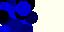

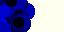

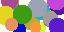

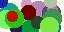

In [47]:
from IPython.display import Image

display(Image(f'{INPUT}/synimg/train/Luanda/train-Luanda-1000000.jpg'))
display(Image(f'{INPUT}/synimg/train/Luanda/train-Luanda-1000001.jpg'))
display(Image(f'{INPUT}/synimg/train/Brisbane/train-Brisbane-1090000.jpg'))
display(Image(f'{INPUT}/synimg/train/Brisbane/train-Brisbane-1090001.jpg'))

# Check out test data

In [48]:
!ls $INPUT/synimg/test

A                D                G                J
B                E                H                data_nostyle.csv
C                F                I


In [49]:
test = pd.read_csv(f'{INPUT}/synimg/test/data_nostyle.csv')

In [50]:
test.head()

,id,file,filepath
0,9000000,test-A-9000000.jpg,synimg/test/A/test-A-9000000.jpg
1,9000001,test-B-9000001.jpg,synimg/test/B/test-B-9000001.jpg
2,9000002,test-C-9000002.jpg,synimg/test/C/test-C-9000002.jpg
3,9000003,test-D-9000003.jpg,synimg/test/D/test-D-9000003.jpg
4,9000004,test-E-9000004.jpg,synimg/test/E/test-E-9000004.jpg


In [51]:
test.shape

(20000, 3)

In [52]:
!ls $INPUT/synimg/test/A | head -n1
!ls $INPUT/synimg/test/B | head -n1

test-A-9000000.jpg
test-B-9000001.jpg


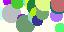

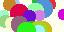

In [53]:
from IPython.display import Image

display(Image(f'{INPUT}/synimg/test/A/test-A-9000000.jpg'))
display(Image(f'{INPUT}/synimg/test/B/test-B-9000001.jpg'))

# Get image size

In [56]:
import tensorflow as tf

image = tf.keras.preprocessing.image.load_img(f'{INPUT}/synimg/test/A/test-A-9000000.jpg')
image.height, image.width

(32, 64)

In [57]:
image.getbands()

('R', 'G', 'B')

In [58]:
image_shape = (image.height, image.width, len(image.getbands()))
image_shape

(32, 64, 3)

# Create label encoder

In [54]:
import sklearn.preprocessing

label_encoder = sklearn.preprocessing.LabelBinarizer()
label_encoder.fit(styles['style_name'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [55]:
import numpy as np

display(label_encoder.classes_)
display(label_encoder.transform(['HongKong', 'Zurich', 'Syndey', 'Zurich']))
display(label_encoder.inverse_transform(np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])))

array(['Beijing', 'Brisbane', 'Geneva', 'HongKong', 'Luanda', 'Melbourne',
       'Seoul', 'Singapore', 'Sydney', 'Zurich'], dtype='<U9')

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

array(['HongKong', 'Zurich'], dtype='<U9')

# Data processing functions

In [59]:
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn.model_selection

def load_image(filepath):
    return np.asarray(tf.keras.preprocessing.image.load_img(f'{INPUT}/{filepath}')) / 255.0

def load_images(filepaths):
    return np.asarray([load_image(filepath) for filepath in filepaths])

def load_labels(labels):
    return label_encoder.transform(labels)

def load_data(df):
    images = load_images(df['filepath'])
    labels = load_labels(df['style_name'])
    return sklearn.model_selection.train_test_split(images, labels, test_size=0.25)

In [60]:
import unittest

class TestLoadImages(unittest.TestCase):
    def test_load_image(self):
        result = load_image('synimg/test/A/test-A-9000000.jpg')
        self.assertTrue(isinstance(result, np.ndarray))
        self.assertEqual(result.dtype, 'float64')
        self.assertEqual(result.shape, image_shape)
        self.assertTrue((result >= 0.0).all() and (result <= 1.0).all())
    def test_load_images(self):
        result = load_images(['synimg/test/A/test-A-9000000.jpg', 'synimg/test/B/test-B-9000001.jpg'])
        self.assertEqual(result.shape, (2, *image_shape))

class TestLoadData(unittest.TestCase):
    def test_load_data(self):
        df = pd.DataFrame({
            'style_name': [
                'Luanda',
                'Luanda',
                'Brisbane',
                'Brisbane'
            ],
            'filepath': [
                'synimg/train/Luanda/train-Luanda-1000000.jpg',
                'synimg/train/Luanda/train-Luanda-1000001.jpg',
                'synimg/train/Brisbane/train-Brisbane-1090000.jpg',
                'synimg/train/Brisbane/train-Brisbane-1090001.jpg'
            ]
        })
        X_train, X_test, y_train, y_test = load_data(df)
        self.assertEqual((X_train.shape, y_train.shape), ((3, *image_shape), (3, len(styles))))
        self.assertEqual((X_test.shape, y_test.shape), ((1, *image_shape), (1, len(styles))))

unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.031s

OK


# Load data

In [62]:
train_images, test_images, train_labels, test_labels = load_data(train)

# Create model

In [63]:
#!pip uninstall -y ethnicolr # needed on Kaggle due to tensorflow 1 dependency
#!pip install -q tensorflow==2.0.0-beta1

In [64]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(styles), activation='softmax'))

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 12, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

# Train model

In [66]:
train_images.shape, train_labels.shape

((75000, 32, 64, 3), (75000, 10))

In [71]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5)

Train on 75000 samples
Epoch 1/5
75000/75000 [==============================] - 128s 2ms/sample - loss: 0.8670 - accuracy: 0.6335
Epoch 2/5
75000/75000 [==============================] - 128s 2ms/sample - loss: 0.6883 - accuracy: 0.7125
Epoch 3/5
75000/75000 [==============================] - 138s 2ms/sample - loss: 0.5365 - accuracy: 0.7839
Epoch 4/5
75000/75000 [==============================] - 146s 2ms/sample - loss: 0.4315 - accuracy: 0.8274
Epoch 5/5
75000/75000 [==============================] - 138s 2ms/sample - loss: 0.3682 - accuracy: 0.8523


# Evaluate model

In [72]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

25000/25000 [==============================] - 14s 563us/sample - loss: 0.3864 - accuracy: 0.8474


# Run predictions

In [75]:
real_test_images = load_images(test['filepath'])
predictions = model.predict(real_test_images)
prediction_labels = label_encoder.inverse_transform(predictions)
prediction_labels

array(['Sydney', 'Melbourne', 'Melbourne', ..., 'Singapore', 'Luanda',
       'HongKong'], dtype='<U9')

# Submit predictions

In [76]:
!head $INPUT/sample_submission.csv

id,style_name
9000000,Brisbane
9000001,Sydney
9000002,Melbourne
9000003,Geneva
9000004,Geneva
9000005,Beijing
9000006,Geneva
9000007,Melbourne
9000008,Beijing


In [80]:
import pandas as pd

submission = test[['id']].assign(style_name = prediction_labels)
submission.head()

,id,style_name
0,9000000,Sydney
1,9000001,Melbourne
2,9000002,Melbourne
3,9000003,Singapore
4,9000004,Brisbane


In [83]:
OUTPUT='../output'
submission.to_csv(f'{OUTPUT}/submission.csv', index=False)

In [84]:
!head $OUTPUT/submission.csv

id,style_name
9000000,Sydney
9000001,Melbourne
9000002,Melbourne
9000003,Singapore
9000004,Brisbane
9000005,Singapore
9000006,HongKong
9000007,Beijing
9000008,Sydney


In [85]:
!kaggle competitions submit -c synthetic-image-classification -f $OUTPUT/submission.csv -m ''

100%|████████████████████████████████████████| 314k/314k [00:10<00:00, 31.9kB/s]
Successfully submitted to Synthetic Image Classification